In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
sns.set()

In [4]:
def ReadSignals(data_dir):
    merged_data = pd.DataFrame()
    # names of the entries in the directory given by path
    for file in os.listdir(data_dir):
        data = pd.read_csv(os.path.join(data_dir, file), sep='\t')
        data_mean_abs = np.array(data.abs().mean())
        data_mean_abs = pd.DataFrame(data_mean_abs.reshape(1,4))
        data_mean_abs.index = [file]
        merged_data = merged_data.append(data_mean_abs)
    merged_data.columns = ['Bearing 1',
                           'Bearing 2',
                           'Bearing 3',
                           'Bearing 4']
    merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
    merged_data = merged_data.sort_index()
    return merged_data


In [5]:
signals = ReadSignals(data_dir = '/Users/jasonchan/Documents/DataProjects/bearing/2nd_test')

In [9]:
def MinMaxScale(df):
    # only normalize columns with numbers
    df_num = df.select_dtypes(include= [np.number])
    # min-max scale
    df_norm = (df_num - df_num.min()) / (df_num.max() - df_num.min())
    return df_norm

In [10]:
normalized_signals = MinMaxScale(df = signals)

In [11]:
# train-test split
train = normalized_signals['2004-02-12 11:02:39':'2004-02-13 23:52:39']
test = normalized_signals['2004-02-13 23:52:39':]

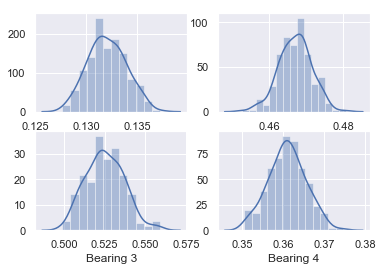

In [12]:
# are signals normally distributed
fig = plt.figure()

plt.subplot(2, 2, 1)
sns.distplot(train['Bearing 1'])

plt.subplot(2, 2, 2)
sns.distplot(train['Bearing 2'])

plt.subplot(2, 2, 3)
sns.distplot(train['Bearing 3'])

plt.subplot(2, 2, 4)
sns.distplot(train['Bearing 4'])

plt.show()

In [17]:
# PCA

# train PC
pca = PCA(n_components=2, svd_solver= 'full')
train_PCA = pca.fit_transform(train)
train_PCA = pd.DataFrame(train_PCA)
train_PCA.index = train.index

# test PC
test_PCA = pca.transform(test)
test_PCA = pd.DataFrame(test_PCA)
test_PCA.index = test.index

In [123]:
# Mahalonobis Distance

def InvCovMatrix(df):
    cov_matrix = np.cov(df, rowvar = False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    return inv_cov_matrix

def CalculateMahalanobis(df, mean_dist, inv_cov_matrix):
    df_copy = df.copy()
    diff = np.array(df - mean_dist)
    distances = []
    for i in diff:
        dist = i.dot(inv_cov_matrix).dot(i)
        distances.append(np.sqrt(dist))
    df_copy['mahal_distance'] = distances
    return df_copy

In [124]:
mb_train = CalculateMahalanobis(df = train_PCA,
                               mean = np.mean(train_PCA),
                              inv_cov_matrix = InvCovMatrix(train_PCA))

mb_test = CalculateMahalanobis(df = test_PCA,
                              mean_dist = np.mean(train_PCA),
                              inv_cov_matrix = InvCovMatrix(train_PCA))

treshold = np.mean(mb_train['mahal_distance']) * 3

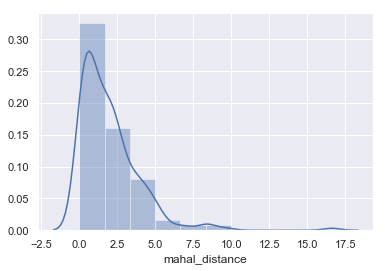

In [127]:
# check chi square
sns.distplot(np.square(mb_train['mahal_distance']), bins = 10)

(0.0, 5)

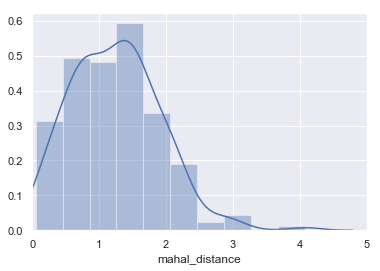

In [132]:
sns.distplot(mb_train['mahal_distance'], bins = 10)
plt.xlim([0.0,5])


In [137]:
np.sqrt(np.var(mb_train['mahal_distance']))

0.6599623339623156